In [1]:
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

In [14]:
events2measure = ["like",
"newfriend",
"post",
"adview",
"dislike",
"unfriend",
"message",
"reply"]

In [ ]:
csv_write_directory = 'event-csvs'
query_directory = 'event-queries'

host = os.environ['DB_HOST']
port = os.environ['DB_PORT']
dbname = os.environ['DB_NAME']
user = os.environ['DB_USER']
password = os.environ['DB_PASSWORD']

In [17]:
connection = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

# simulation covers the period 01/01/2020 to 30/06/2020
parameters = {
    'from_yyyy-mm-dd': '2020-01-01',
    'to_yyyy-mm-dd': '2020-06-30',
}


# read the SQL query template
query_path = query_directory + '/' + 'check-events-per-day' + '.sql'
with open(query_path, 'r') as file:
    sql_script = file.read()

# create a cursor to execute SQL queries
cursor = connection.cursor()

for event_name in events2measure:
    # prepare and execute the query
    parameters.update({'event2measure': event_name})
    cursor.execute(sql_script, parameters)

    # retrieve the results
    results = cursor.fetchall()

    # create a pandas DataFrame from the results
    df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

    # write to csv
    csv_write_path = csv_write_directory + '/' + event_name + '.csv'
    df.to_csv(csv_write_path, index=False, mode='w')
    del df

# close the cursor and the connection
cursor.close()
connection.close()

It's worth spending some time checking the quality of the event data before we calculate metrics. We can look for anomalies in the aggregated total number of events for all customers for each event type by plotting how these totals change over time.

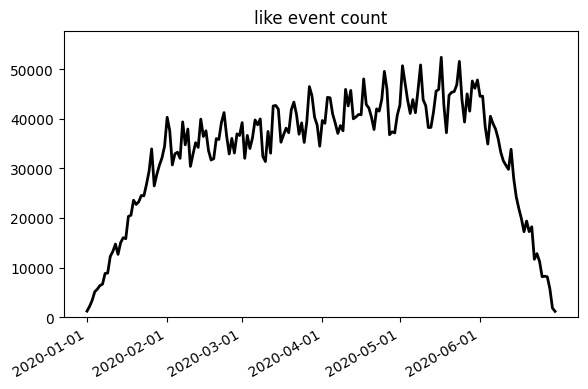

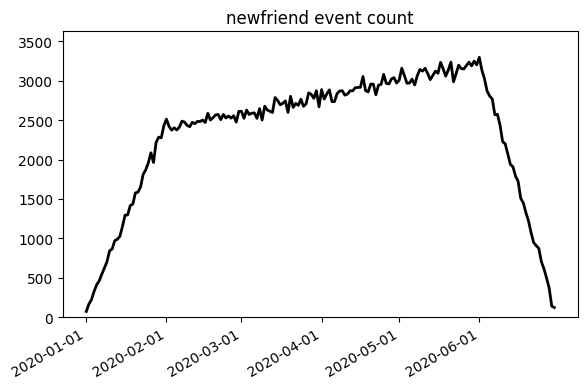

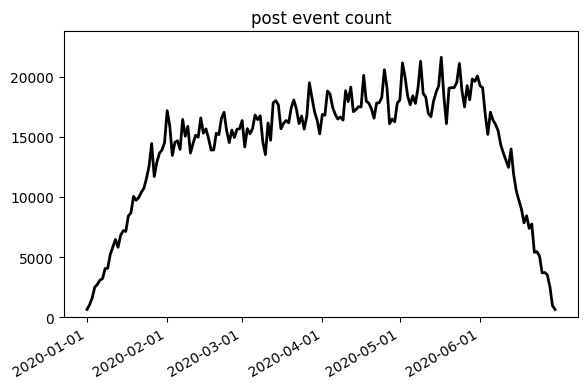

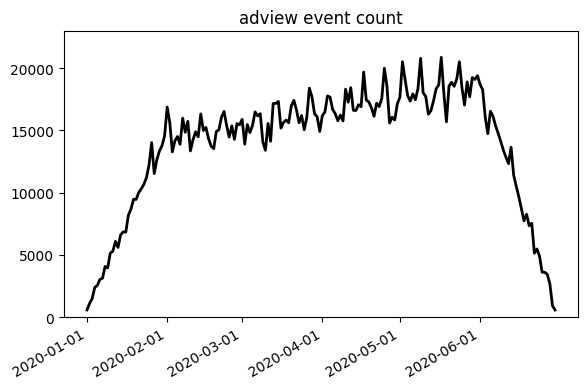

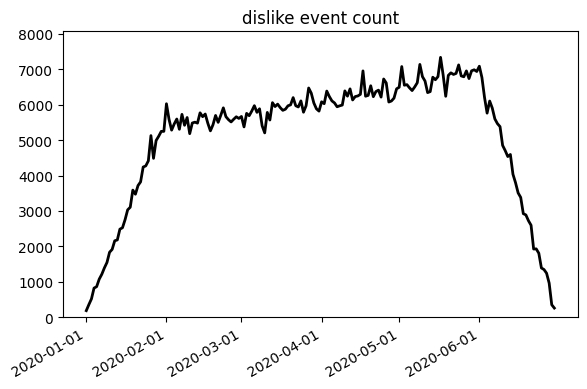

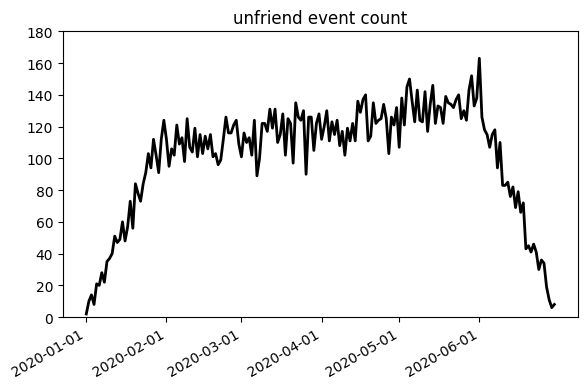

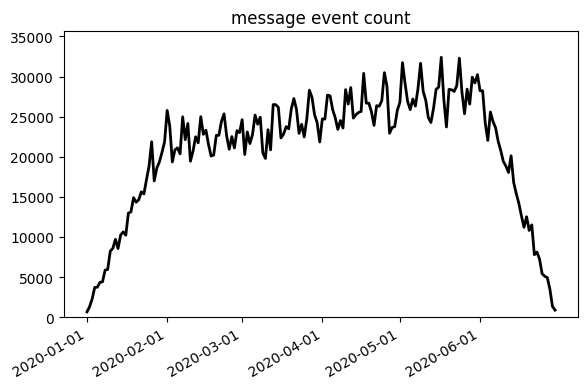

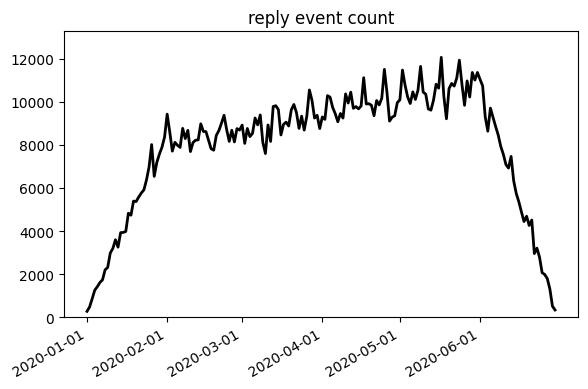

In [18]:
# read in the qa data for the relevant event metrics:
for event_name in events2measure:
    # read in event qa from csv
    csv_read_path = 'event-csvs/' + event_name + '.csv'
    qa_data_df = pd.read_csv(csv_read_path)

    plt.figure(figsize=(6, 4))
    plt.plot('event_date', 'n_event', data=qa_data_df, marker='', color='black', linewidth=2)
    plt.ylim(0, ceil(1.1 * qa_data_df['n_event'].dropna().max()))
    plt.title('{} event count'.format(event_name))
    plt.gca().figure.autofmt_xdate()
    plt.xticks(list(filter(lambda x:x.endswith(("01")),qa_data_df['event_date'].tolist())))
    plt.tight_layout()
    
    plt.show()